# Introduction
We work through a problem posed in Chapter 8 of {% cite fastbook2020 %}.

In [3]:
#| include: false
!pip install git+https://github.com/fastai/fastai
!pip install git+https://github.com/fastai/fastcore

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-zjxoy0df
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-zjxoy0df
     |████████████████████████████████| 56 kB 3.7 MB/s 
  Created wheel for fastai: filename=fastai-2.5.4-py3-none-any.whl size=187080 sha256=6d44558f6819ca22d8156040d24a0c6151f45083aae42ea168cc6c282c8c8f40
  Stored in directory: /tmp/pip-ephem-wheel-cache-tfsrljv0/wheels/40/be/4f/b7f2aec4df5712626ceed9f20a8996eb05e31244e57e58d632
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-1zb41_u5
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-1zb41_u5
  Created wheel for fastcore: filename=fastcore-1.3.28-py3-none-any.whl size=55627 sha256=64a245b7f8d582bfea4dc21b66117fa96f76de0717a5e8f28fa9f0de84c2c00d
  Stored in directory: /tmp/pip-ephem-wheel-cache-g7qipgl6/wheels/74/46/b7/0d3dddeb22ca1b6f226a3d5b096df11a632951327002d86f1f
Successfully built fastcore
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.3.27
    Uninstalling fastcore-1.3.27:
      Successfully uninstalled fastcore-1.3.27


In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [2]:
Path.BASE_PATH = path
path.ls()

(#23) [Path('u1.base'),Path('u1.test'),Path('u4.test'),Path('allbut.pl'),Path('u.item'),Path('ua.test'),Path('u.occupation'),Path('u3.test'),Path('u5.base'),Path('ub.test')...]

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


We see that the rating can be one of the following values:

In [4]:
ratings.rating.unique()

array([3, 1, 2, 4, 5])

In [5]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


# DataLoaders

In [7]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,328,Star Trek VI: The Undiscovered Country (1991),3
1,251,Toy Story (1995),4
2,456,Judgment Night (1993),2
3,653,Raiders of the Lost Ark (1981),5
4,551,Aliens (1986),4
5,416,"Edge, The (1997)",4
6,116,Good Will Hunting (1997),3
7,500,Chain Reaction (1996),3
8,393,Barb Wire (1996),3
9,227,Father of the Bride Part II (1995),3


# Probabilistic Matrix Factorization baseline

Underneath the covers we have a dot product model (where the dot product is between the user embedding and the item embedding). We use L2 regularization (wd=0.5) and use y_range to make sure the sigmoid_range can get to a rating of $5$. Recall that in the sigmoid function only an activation of $\infty$ will get us a $1$. This will use the MSE as the loss function.

In [8]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.938077,0.954516,00:09
1,0.845044,0.872871,00:09
2,0.723613,0.843354,00:18
3,0.586253,0.829404,00:09
4,0.491200,0.829491,00:10


So $0.829$ is what we want to beat!

# Deep Learning baseline
Instead of a Dot Product model we use a model where the user and the movie embeddings are concatenated together and then passed through a neural net. We continue to use MSE as our loss.

In [9]:
learn2 = collab_learner(dls, n_factors=50, use_nn=True, layers=[100], y_range=(0,5.5))
learn2.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.991514,0.999929,00:12
1,0.940058,0.930773,00:13
2,0.867342,0.879026,00:12
3,0.810829,0.855366,00:12
4,0.753963,0.852470,00:12


The model is as follows:

In [10]:
learn2.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=1, bias=True)
    )
    (2): SigmoidRange(low=0, high=5.5)
  )
)

# Cross Entropy Loss
Turn each rating into a class label by subtracting one. Recall we saw that ratings are integers from $1$ to $5$.

In [11]:
ratings['class'] = ratings['rating'] - 1
ratings.head(n=5)

,user,movie,rating,timestamp,title,class
0,196,242,3,881250949,Kolya (1996),2
1,63,242,3,875747190,Kolya (1996),2
2,226,242,5,883888671,Kolya (1996),4
3,154,242,3,879138235,Kolya (1996),2
4,306,242,5,876503793,Kolya (1996),4


In [12]:
ratings['class'].unique()

array([2, 4, 3, 1, 0])

In [13]:
dls3 = CollabDataLoaders.from_df(ratings, item_name='title', rating_name='class', bs=64)
dls3.show_batch()

,user,title,class
0,581,Return of the Jedi (1983),2
1,159,Courage Under Fire (1996),3
2,521,"Long Kiss Goodnight, The (1996)",3
3,533,"Stupids, The (1996)",0
4,77,Brazil (1985),3
5,12,"Lion King, The (1994)",3
6,605,"Usual Suspects, The (1995)",3
7,561,Richard III (1995),2
8,246,"Doors, The (1991)",0
9,658,"Boot, Das (1981)",4


Create a class that is able to output as many activations as there are classes.

In [14]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, n_act=100, n_classes=5):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, n_classes))
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        return self.layers(torch.cat(embs, dim=1))

In [15]:
embs = get_emb_sz(dls3)
embs

[(944, 74), (1665, 102)]

In [16]:
model = CollabNN(*embs)

Examine a batch of inputs and outputs

In [17]:
x, y = dls3.one_batch()
x[:3], y[:3]

(tensor([[ 763, 1211],
         [ 474, 1006],
         [ 261,  734]]), tensor([[3],
         [4],
         [3]], dtype=torch.int8))

Get activations by passing through the model

In [18]:
model(x[:3])

tensor([[ 0.1065, -0.0083, -0.1098, -0.1151, -0.0471],
        [ 0.1053, -0.0053, -0.1108, -0.1145, -0.0490],
        [ 0.1017, -0.0110, -0.1114, -0.1135, -0.0478]],
       grad_fn=<AddmmBackward0>)

Apply softmax to the activations

In [19]:
torch.softmax(model(x[:3]), dim=-1)

tensor([[0.2296, 0.2047, 0.1849, 0.1839, 0.1969],
        [0.2293, 0.2053, 0.1848, 0.1841, 0.1965],
        [0.2289, 0.2045, 0.1850, 0.1846, 0.1971]], grad_fn=<SoftmaxBackward0>)

Take the argmax to get the prediction of the class

In [20]:
torch.softmax(model(x[:3]), dim=-1).argmax(dim=-1)

tensor([0, 0, 0])

Unsqueeze to match the shape of the y's

In [21]:
torch.softmax(model(x[:3]), dim=-1).argmax(dim=-1).unsqueeze(-1)

tensor([[0],
        [0],
        [0]])

Convert to float and compute the mse_loss

In [22]:
F.mse_loss(torch.softmax(model(x[:3]), dim=-1).argmax(dim=-1).unsqueeze(-1).float(), y[:3])

tensor(11.3333)

Create our custom mse function that can get a loss from these activations for the different classes. We do this so we can compare the validation loss metric against the previous baselines. Clearly cross entropy loss cannot be compared directly to the mean squared error.

In [23]:
def ks_mse(inp, targ, axis=-1):
    sm_acts = torch.softmax(inp, dim=-1)
    preds = sm_acts.argmax(dim=axis).unsqueeze(-1)
    return F.mse_loss(preds.float(), targ)

Compare with our custom function

In [24]:
ks_mse(model(x[:3]), y[:3])

tensor(11.3333)

In [30]:
learn3 = Learner(dls3, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, ks_mse])

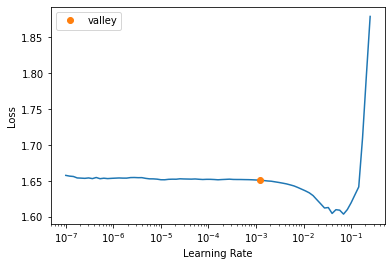

In [26]:
lrs = learn3.lr_find()

In [28]:
lrs

SuggestedLRs(valley=0.0012022644514217973)

In [31]:
learn3.fit_one_cycle(5, lrs.valley)

epoch,train_loss,valid_loss,accuracy,ks_mse,time
0,1.177951,1.238908,0.444100,1.217100,00:13
1,1.186859,1.232669,0.448450,1.215550,00:13
2,1.168161,1.228795,0.452750,1.146900,00:12
3,1.132046,1.233022,0.451050,1.154100,00:12
4,1.096163,1.237107,0.450800,1.162600,00:13


Unfortunately, in this attempt, we came up short and were unable to beat the baseline.

Finally, let's use a confusion matrix to visualize where this model is coming up short.

In [49]:
raw_preds, targs, decoded_preds = learn3.get_preds(with_decoded=True)
raw_preds[:3], decoded_preds[:3], targs[:3]

(tensor([[0.0255, 0.2153, 0.2651, 0.4588, 0.0353],
         [0.0089, 0.0586, 0.2399, 0.4129, 0.2797],
         [0.0028, 0.1422, 0.3484, 0.3990, 0.1076]]),
 tensor([3, 3, 3]),
 tensor([[4],
         [4],
         [3]], dtype=torch.int8))

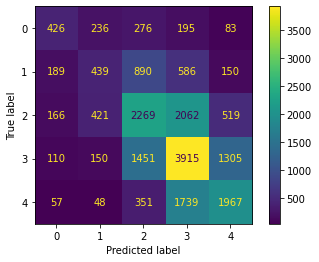

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(targs, decoded_preds)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(targs, decoded_preds, labels=[0, 1, 2, 3, 4]))

              precision    recall  f1-score   support

           0       0.45      0.35      0.39      1216
           1       0.34      0.19      0.25      2254
           2       0.43      0.42      0.43      5437
           3       0.46      0.56      0.51      6931
           4       0.49      0.47      0.48      4162

    accuracy                           0.45     20000
   macro avg       0.43      0.40      0.41     20000
weighted avg       0.44      0.45      0.44     20000



# References
{% bibliography --cited %}